In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import spacy
from gensim import corpora,models, similarities
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
# Pra não truncar as strings
pd.set_option('display.max_colwidth', -1)

In [4]:
ufpe = pd.read_csv('ufpe.csv')
carnegie = pd.read_csv('carnegie.csv')

In [5]:
ufpe = ufpe[ufpe['abstract'] != "Not found"]
ufpe = ufpe.reset_index(drop=True)

In [6]:
len(ufpe)

151

In [7]:
carnegie_sample = carnegie.sample(151)
print(len(carnegie_sample))

151


In [8]:
nlp = spacy.load('en')

In [9]:
def get_parsed_data(model,data):
    parsedData = []
    for d in data:
        parsedData.append(model(d))
        
    return parsedData

In [10]:
def get_lemma(doc):
    tokens = []
    for token in doc:
        if not token.is_punct and (not token.is_digit) and (not token.is_stop):
            if(len(token.lemma_) > 2):
                tokens.append(token.lemma_)
            
    return tokens

## Colocar os dados das duas Universidades em um mesmo dataframe

In [11]:
data_ufpe_with_words = []
for i,row in ufpe.iterrows():
    title = row['title']
    university = row['university']
    year = row['year']
    id_row = i
    words = get_lemma(nlp(row['abstract']))
    data_ufpe_with_words.append({'title':title,'university':university,'year':year,'i':id_row,'words':words})

In [12]:
data_carnegie_with_words = []
for i,row in carnegie_sample.iterrows():
    title = row['title']
    university = row['university']
    year = row['year']
    id_row = i
    words = get_lemma(nlp(row['abstract']))
    data_carnegie_with_words.append({'title':title,'university':university,'year':year,'i':id_row,'words':words})

In [13]:
total_tccs = data_ufpe_with_words + data_carnegie_with_words

In [14]:
len(pd.DataFrame.from_dict(data_carnegie_with_words))

151

In [15]:
len(pd.DataFrame.from_dict(data_ufpe_with_words))

151

In [16]:
len(pd.DataFrame.from_dict(total_tccs))

302

In [17]:
pd.DataFrame.from_dict(total_tccs)

,i,title,university,words,year
0,0,ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR,UFPE,"[work, aim, study, dynamically, reconfigurable, architecture, digital, system, fast, prototipation, base, leon, cpu, previously, establish, platform, architecture, study, consider, dynamic, reconfiguration, instruction, leon, system, virtex, platform, proposal, virtex, component, house, leon, cpu, core, structure, integration, fixed, area, fpga, instruction, structure, dynamically, modify, necessary, stop, processor, fly, reconfiguration]",2004
1,1,INTEGRATING UML AND FORMAL METHODS,UFPE,"[uml, widespread, language, industry, academia, se-, mantic, informal, ambiguity, hand, ohcircus, formal, specification, language, unify, csp, refinement, cal-, culu, object, orient, theory, work, concerned, integration, translate, uml, clas, diagram, ohcircus, specification, particular, approach, use, syntactic, mapping, concept, clas, model, capture, naturally, association, global, constraint, finally, use, work, prove, refinement, association, attribute, desire, result, link, analysi, design, implementation]",2004
2,2,A Service Development Specification for Interactive Digital Television,UFPE,"[television, future, digital, interactivity, televiewer, receive, signal, high, quality, video, audio, natural, evolution, great, contribution, interactivity, promote, utopia, social, inclusion, proces, provide, computing, capability, set, allow, people, access, internet, mail, vanguard, scenario, deep, analysi, interactive, service, need, consider, current, communication, technology, conceive, design, develop, main, subject, work, show, introduction, interactive, digital, television, middleware, present, support, service, application, application, manager, proposal]",2005
3,3,Electronic Tele-Stethoscope A TOOL IN TELEMEDICINE AND CARDIOLOGY EDUCATION,UFPE,"[teaching, cardiology, start, patient, physical, examination, important, aspect, auscultation, cardiac, sound, training, medical, student, auscultation, different, cardiac, sound, key, step, establishment, clinical, diagnosi, monography, infrastructure, build, hospital, support, personal, computer, allow, recording, cardiac, sound, child, neonatal, period, purpose, device, design, develop, heart, sound, capture, software, recording, reproduction, sound, result, monograph, digital, heart, sound, record, system, hardware, software, build, system, allow, reproduction, amplification, sound, hear, loudspeaker, transmission, throught, mail]",2005
4,4,Managing software projects in companies with different maturity levels,UFPE,"[know, successful, software, development, company, base, efficient, project, management, methodology, task, simple, firstly, available, model, like, pmbok, generic, project, nature, software, development, second, model, apply, companies’, size, structure, paper, approach, aspect, objective, identify, enterprise, lifecycle, model, classify, company, accord, maturity, apply, software, enterprise, identify, software, development, project, management, proces, model, detail, subprocess, technique, input, output, artifact, associate, item, subprocess, stage, item, model]",2005
5,5,Bizpro system for publishing financial reports in xbrl,UFPE,"[fast, growth, internet, revolutionize, way, company, deliver, financial, information, today, 99%, large, company, world, web, sites, 94%, site, include, financial, information, standard, spreading, information, hypertext, markup, language, html, portable, document, format, pdf, great, problem, inhabit, non-, standard, format, information, finish, way, make, difficult, acces, user, application, objective, work, consider, system, creation, distribution, management, financial, report, xml, development, initiate, research, context, exist, language, purpose, consider, architecture, bizpro, system, detail, module, management, acces, control, police, new, object, model, xbrldom, extend, model, dom, w3c., module, management, acce

In [18]:
all_tccs = pd.DataFrame.from_dict(total_tccs)

## Criar os clusters

### Referência
A análise que Frank Cleary fez sobre a Modelagem de Tópicos para personagens de Shakespeare foi crucial pra criação do que vem a partir daqui: http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/

In [19]:
abstract_list = all_tccs['words'].values

# corpora.Dictionary(): Dictionary encapsulates the mapping between normalized words and their integer ids.
dictionary = corpora.Dictionary(abstract_list)
print(dictionary)

appear_once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

# filter_tokens(): Remove the selected bad_ids tokens from all dictionary mappings
dictionary.filter_tokens(appear_once_ids)

# compactify(): Assign new word ids to all words
dictionary.compactify()

print(dictionary)

Dictionary(4389 unique tokens: ['equivalence', 'permission', 'inference', 'nibble', 'eye']...)
Dictionary(2077 unique tokens: ['inference', 'recall', 'sort', 'categorize', 'powerful']...)


In [20]:
# doc2bow(): Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples
corpus = [dictionary.doc2bow(words) for words in abstract_list]

#corpora.mmcorpus.MmCorpus.serialize('data/shkspr.mm', corpus)

# TfidfModel(): word-document co-occurrence matrix (integers) into a locally/globally weighted TF_IDF matrix (positive floats)
tfidf = models.TfidfModel(corpus)

In [21]:
# LsiModel():  Latent Semantic Analysis (aka Latent Semantic Indexing)
lsi = models.lsimodel.LsiModel(corpus=tfidf[corpus], id2word=dictionary,num_topics=4,power_iters=50,onepass=False,chunksize=20)
#lsi.save('data/shkspr.lsi')
for i, topic in enumerate(lsi.print_topics(5)):
    print('Topic {}:'.format(i))
    print(topic[1].replace(' + ', "\n"))
    print('')

Topic 0:
0.140*"model"
0.126*"software"
0.119*"system"
0.118*"project"
0.118*"tool"
0.111*"algorithm"
0.106*"datum"
0.105*"object"
0.100*"problem"
0.100*"language"

Topic 1:
0.294*"object"
-0.222*"software"
0.205*"algorithm"
0.185*"robot"
-0.176*"model"
-0.165*"project"
-0.156*"busines"
-0.152*"management"
-0.136*"process"
0.128*"visual"

Topic 2:
0.393*"game"
-0.332*"object"
-0.190*"robot"
0.163*"network"
-0.156*"software"
-0.144*"model"
-0.143*"project"
-0.119*"recognition"
-0.115*"environment"
-0.112*"management"

Topic 3:
0.600*"game"
-0.203*"network"
0.173*"object"
0.149*"english"
-0.130*"wireless"
0.126*"representation"
0.122*"player"
-0.108*"acces"
-0.100*"protocol"
0.099*"tool"



## Cria tuplas para mostrar os títulos dos trabalhos na visualização

In [22]:
papers = [tuple(character) for character in all_tccs[['title', 'university']].values]
universities = all_tccs['university'].unique()

In [23]:
papers

[('ARCHITECTURE FOR STATIC AND DYNAMIC RECONFIGURATION OF INSTRUCTIONS IN THE LEON PROCESSOR',
  'UFPE'),
 ('INTEGRATING UML AND FORMAL METHODS', 'UFPE'),
 ('A Service Development Specification for Interactive Digital Television',
  'UFPE'),
 ('Electronic Tele-Stethoscope A TOOL IN TELEMEDICINE AND CARDIOLOGY EDUCATION',
  'UFPE'),
 ('Managing software projects in companies with different maturity levels',
  'UFPE'),
 ('Bizpro system for publishing financial reports in xbrl', 'UFPE'),
 ('REGISTRATION MODULE IN VIRTUAL TEACHING ENVIRONMENTS: SPECIFICATION OF FUNCTIONAL AND STRUCTURAL ASPECTS',
  'UFPE'),
 ('A PROCESS FOR EVALUATING SOFTWARE PRODUCTS THROUGH SPECIALIST ANALYSIS',
  'UFPE'),
 ('Mapping of the CMMI Model To ISO / IEC 12207', 'UFPE'),
 ('REUSABLE COMPONENT IDENTIFICATION FROM EXISTING OBJECT-ORIENTED PROGRAMS TOWARDS AN AUTOMATIC COMPONENT LOAD TOOL',
  'UFPE'),
 ('An assessment of multiple project management tools', 'UFPE'),
 ('Study and state of the art of the automatic t

In [24]:
# Calculate a similarity value between each tcc
matsim = similarities.MatrixSimilarity(lsi[tfidf[corpus]], num_best=6)

In [25]:
def format_topic_coeffs(topic):
    """Return a list of coefficent, word tuples with coefficent truncated to 
    3 decimal places.
    """
    return [(coeff, word) for coeff, word in topic]

def plot_axes(x=0, y=1, model=lsi, corpus=corpus, 
              tfidf=tfidf, papers=papers, universities=universities):
    x_data = defaultdict(list)
    y_data = defaultdict(list)
    chars = defaultdict(list)
    print('x topic:')
    pprint(format_topic_coeffs(model.show_topic(x)))
    print('')
    print('y topic:')
    pprint(format_topic_coeffs(model.show_topic(y)))
    for paper, doc in zip(papers, corpus):
        university = paper[1]
        if len(model[tfidf[doc]]) != 0:
            x_data[university].append((model[tfidf[doc]][x][1]))
            y_data[university].append((model[tfidf[doc]][y][1]))
            '''Remove the comment of the next line to show titles of each work'''
            #chars[university].append(paper[0])
        
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    cmap = plt.get_cmap('Paired')
    university_index = {university: i for i, university in enumerate(universities)}
    for university in university_index:
        color_index = university_index[university] / float(len(university_index))
        plt.scatter(x_data[university], y_data[university], color=cmap(color_index), 
                    label=university, alpha=.5, s=40)
        for char, x, y in zip(chars[university], x_data[university], y_data[university]):
            ax.annotate(char, xy=(x, y), xycoords='data', xytext=(1, 1), 
                        textcoords='offset points', size=10)
    plt.legend(loc=1, ncol=2, scatterpoints=1)

x topic:
[('game', 0.39281295542668371),
 ('object', -0.33209151440065665),
 ('robot', -0.19018555067731424),
 ('network', 0.16257955159257928),
 ('software', -0.15607916831511445),
 ('model', -0.14399276238991335),
 ('project', -0.14322442304348437),
 ('recognition', -0.11947734254757965),
 ('environment', -0.11482880229455512),
 ('management', -0.11242099464889546)]

y topic:
[('object', 0.29383227033104375),
 ('software', -0.22197520420133632),
 ('algorithm', 0.20537550622495102),
 ('robot', 0.18498675015157251),
 ('model', -0.17565360130127983),
 ('project', -0.164945961528315),
 ('busines', -0.15603883815175643),
 ('management', -0.15160458583774569),
 ('process', -0.13630070297362168),
 ('visual', 0.12762128292042879)]


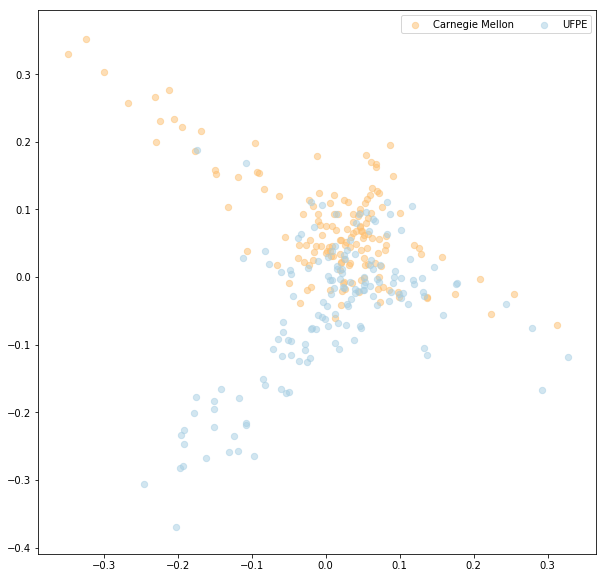

In [26]:
plot_axes(x=2, y=1)

x topic:
[('model', 0.13961918214802166),
 ('software', 0.12616447578289589),
 ('system', 0.11903943969213242),
 ('project', 0.11778039298130047),
 ('tool', 0.11753636917977724),
 ('algorithm', 0.1107100478105872),
 ('datum', 0.10606875210038377),
 ('object', 0.10455545796157528),
 ('problem', 0.099887604402247615),
 ('language', 0.099875561757200387)]

y topic:
[('game', 0.60033689722895178),
 ('network', -0.20338884889713471),
 ('object', 0.17257435372288774),
 ('english', 0.14854485751829513),
 ('wireless', -0.13025500283736052),
 ('representation', 0.1264234051155613),
 ('player', 0.12217778716406166),
 ('acces', -0.10840990814233437),
 ('protocol', -0.1004167066306634),
 ('tool', 0.099265822472455995)]


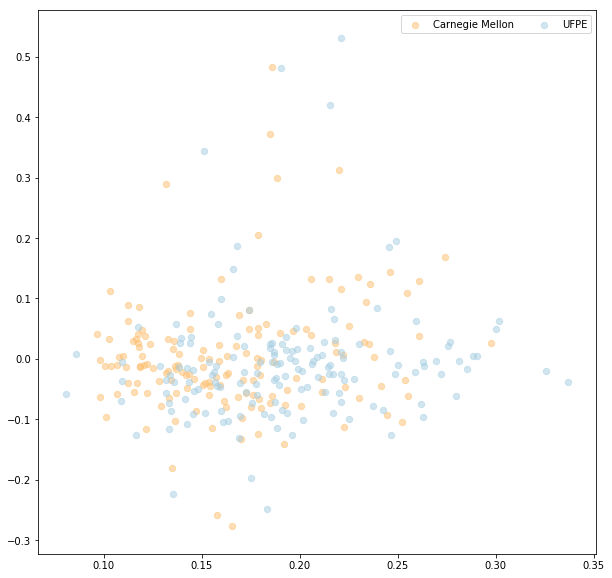

In [27]:
plot_axes(x=0, y=3)